In [ ]:
!pip install kaggle
!mkdir -p /root/.config/kaggle
!sudo cp kaggle.json ~/.config/kaggle/
!sudo chmod 600 ~/.config/kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tapakah68/segmentation-full-body-mads-dataset
!unzip segmentation-full-body-mads-dataset.zip

In [ ]:
!pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git

In [ ]:
from PIL import Image
from lang_sam import LangSAM
import numpy as np
import os
import matplotlib.pyplot as plt
import kaggle
import cv2

model = LangSAM()
text_prompt = "person."

In [8]:
def intersection_over_union_metric(predicted_mask, true_mask):
    predicted_mask = predicted_mask.astype(bool)
    true_mask = true_mask.astype(bool)
    intersection = np.logical_and(predicted_mask, true_mask).sum()
    union = np.logical_or(predicted_mask, true_mask).sum()
    if union == 0:
        return 0.0
    iou = intersection / union
    return iou

In [22]:
def get_contour_mask(true_mask_np):
    h, w = true_mask_np.shape[-2:]
    temp_mask = true_mask_np.astype(np.uint8)
    mask_image =  temp_mask.reshape(h, w)
    contours, _ = cv2.findContours(temp_mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Try to smooth contours
    contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
    zero_mask = np.zeros((h, w), dtype=float)
    final_contours = cv2.drawContours(zero_mask, contours, -1, (1, 1, 1, 0.5), thickness=3)
    return np.logical_and(final_contours, true_mask_np)


# discounts the contour by the threshold
def modified_IOU(predicted_mask, true_mask, threshold = 0.1):
    predicted_mask = predicted_mask.astype(bool)
    true_mask = true_mask.astype(bool)
    contour = get_contour_mask(true_mask)
    union = np.logical_or(predicted_mask, true_mask).sum() - (threshold * np.logical_and(true_mask, contour).sum())
    # intersection = max(0, np.logical_and(predicted_mask, true_mask).sum() - (threshold * np.logical_and(true_mask, contour).sum()))
    intersection = np.logical_and(predicted_mask, true_mask).sum()
    if union <= 0:
        return 0.0
    iou = intersection / union
    return iou

In [20]:
def evaluate_model_on_test_set(test_images_dir='./test_images',
                                test_masks_dir='./test_masks',
                                text_prompt="person.",
                                evaluation_function=intersection_over_union_metric
                                ):
    iou_results = []

    # Ensure the directories exist
    if not os.path.exists(test_images_dir):
        print(f"Test images directory not found: {test_images_dir}")
    elif not os.path.exists(test_masks_dir):
        print(f"Test masks directory not found: {test_masks_dir}")
    else:
        image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

        for image_file in image_files:
            image_path = os.path.join(test_images_dir, image_file)
            mask_file = image_file # Assuming the mask file has the same name as the image file
            mask_path = os.path.join(test_masks_dir, mask_file)

            if not os.path.exists(mask_path):
                print(f"Ground truth mask not found for {image_file}")
                continue

            try:
              # Load the image
              image_pil = Image.open(image_path).convert("RGB")
              image_np = np.array(image_pil)

              # Load the ground truth mask
              # Assuming the ground truth mask is a grayscale image where the wound is white (255) and background is black (0)
              true_mask_pil = Image.open(mask_path).convert("L")
              true_mask_np = np.array(true_mask_pil) > 0 # Convert to boolean mask
              # Predict the mask using LangSAM
              # LangSAM expects a list of images and a list of prompts
              result = model.predict([image_pil], [text_prompt])
              scores = result[0]['scores'] # float array
              boxes = result[0]['boxes']
              masks = result[0]['masks']
              masks_scores = result[0]['mask_scores'] # float array

              if len(masks) == 0:
                  print(f"No Prediction found for {image_file}")
                  iou_results.append({'image': image_file, 'iou': np.nan})
                  continue

              if masks is not None and not(isinstance(masks, list)):
                  if masks_scores.ndim == 0:
                      masks_scores = [masks_scores.item()]
                  if scores.ndim == 0:
                      scores = [scores.item()]

                  # LangSAM masks are shape [num_masks, H, W]
                  max_index = 0
                  for i, predicted_mask in enumerate(masks):
                      # find the mask that has the highest score
                      if masks_scores[max_index] < masks_scores[i]:
                        if scores[max_index] < scores[i]:
                          max_index = i

                  predicted_mask_np = masks[max_index]
                  result_iou = evaluation_function(predicted_mask_np, true_mask_np)

              iou_results.append({'image': image_file, 'iou': result_iou})
              print(f"Processed {image_file}, IoU: {result_iou:.4f}")
            except Exception as e:
                print(f"Error processing {image_file}: {e}")
                iou_results.append({'image': image_file, 'iou': np.nan}) # Append NaN for errors

    # Print average IoU
    if len(iou_results) > 0:
        average_iou = np.nanmean([res['iou'] for res in iou_results])
        print(f"\nAverage IoU across test set: {average_iou:.4f}")
    else:
        print("No images were processed.")

    return iou_results


In [ ]:
test_images_dir = './segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images'
test_masks_dir = './segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks'
text_prompt = "person."

iou_results = evaluate_model_on_test_set(test_images_dir, test_masks_dir, text_prompt, modified_IOU)


In [ ]:
# Sort the iou_results by IoU in ascending order
sorted_iou_results = sorted(iou_results, key=lambda x: x['iou'])

# Get the lowest values and their corresponding image names
lowest_iou_results = sorted_iou_results[:20] # Get the bottom 10

print("Lowest IoU values and corresponding image names:")
for result in lowest_iou_results:
  print(f"Image: {result['image']}, IoU: {result['iou']:.4f}")

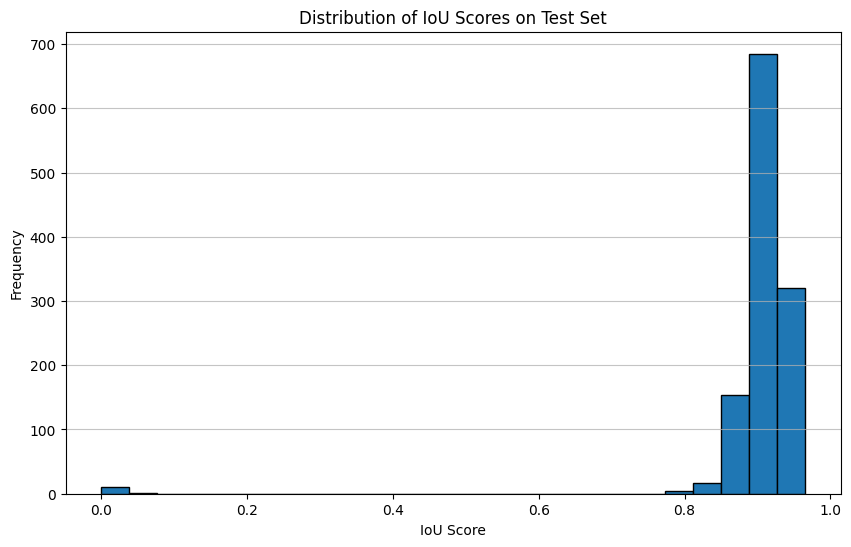

In [24]:
iou_scores = [res['iou'] for res in iou_results if not np.isnan(res['iou'])]

if len(iou_scores) >= 0:
    plt.figure(figsize=(10, 6))
    plt.hist(iou_scores, bins=25, edgecolor='black')
    plt.title('Distribution of IoU Scores on Test Set')
    plt.xlabel('IoU Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()
else:
    print("No valid IoU scores available to plot the histogram.")

In [ ]:
# Compute average IoU
if len(iou_results) > 0:
    # Filter out NaN values before computing the mean
    valid_ious = [res['iou'] for res in iou_results if not np.isnan(res['iou'])]
    if len(valid_ious) > 0:
        average_iou = np.mean(valid_ious)
        print(f"\nAverage IoU across test set: {average_iou:.4f}")
    else:
        print("No valid IoU results were computed.")
else:
    print("No images were processed.")


In [26]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=1)
    ax.imshow(mask_image)

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.5f}", fontsize=18)
        plt.axis('off')
        plt.show()

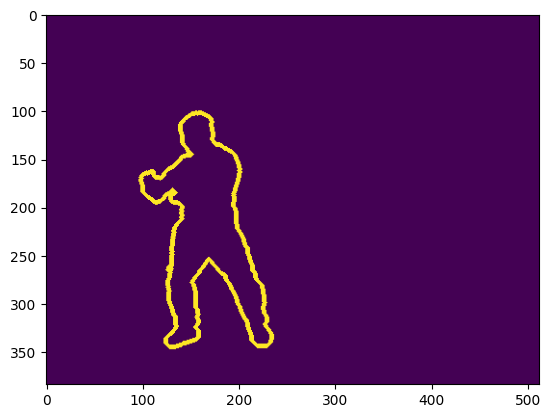

In [31]:
import cv2
color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)

h, w = true_mask_np.shape[-2:]
temp_mask = true_mask_np.astype(np.uint8)
mask_image =  temp_mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
contours, _ = cv2.findContours(temp_mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# Try to smooth contours
contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
zero_mask = np.zeros((h, w), dtype=float)
final_contours = cv2.drawContours(zero_mask, contours, -1, (1, 1, 1, 0.5), thickness=3)
plt.gca().imshow(final_contours)
